# Рекомендация тарифов

Предобработка данных была выполнена ранее - [Определение перспективного тарифа для телеком-компании](https://github.com/SanYattsu/Data_Science_Projects/blob/main/Yandex_Courseworks/Telecom_Tariff_Determination/Tariff-Determination-for-a-Telecom-Company.ipynb).
Нужно провести анализ поведения клиентов пользователей тарифов «Смарт» или «Ультра».

**Цель проекта - построить модель для задачи классификации, которая выберет подходящий тариф.**

**Описание данных**

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Параметры отображения Seaborn.
sns.set_palette('muted')
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2})

# Ограничим число знаков после запятой для вывода табличных данных.
pd.options.display.float_format = '{:0.3f}'.format

Загрузим и посмотрим данные.

In [4]:
try:
    df = pd.read_csv(url + 'users_behavior.csv')
    # Дополнительный датафрейм из предыдущего анализа.
    tariffs = pd.read_csv(url + 'tariffs.csv')
except:
    print('Не удалось загрузить файл, проверьте путь.')

In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.000,311.900,83.000,19915.420,0
1,85.000,516.750,56.000,22696.960,0
2,77.000,467.660,86.000,21060.450,0
3,106.000,745.530,81.000,8437.390,1
4,66.000,418.740,1.000,14502.750,0


In [6]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
df.shape

(3214, 5)

# Исследовательский анализ данных

Построим корреляции чтобы увидеть как связаны независимые параметры. Видна мультиколлинеарность, calls и minutes имеют очевидную положительную связь, логично будет оставить только один из признаков.

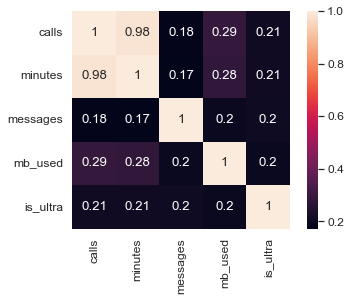

In [8]:
sns.heatmap(df.corr(), annot=True, square=True);

Гистограммы признаков.

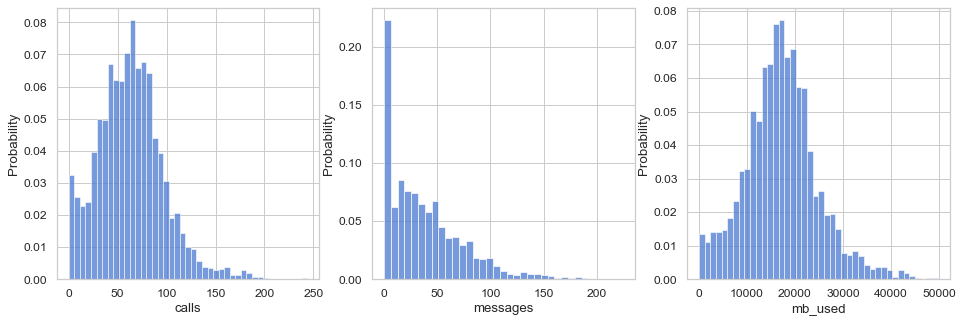

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(data=df, x='calls', stat='probability', ax=axes[0])
sns.histplot(data=df, x='messages', stat='probability', ax=axes[1])
sns.histplot(data=df, x='mb_used', stat='probability', ax=axes[2])
plt.show()

Чтобы распределения независимых переменных приняли более "нормальный" вид пропустим их через log1p().

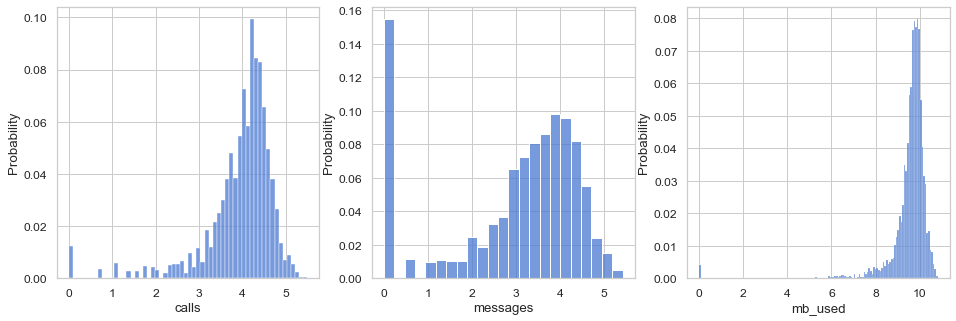

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(data=df, x=np.log1p(df.calls), stat='probability', ax=axes[0])
sns.histplot(data=df, x=np.log1p(df.messages), stat='probability', ax=axes[1])
sns.histplot(data=df, x=np.log1p(df.mb_used), stat='probability', ax=axes[2])
plt.show()

Построим диаграммы размаха. Значения calls выше 150 для is_ultra=0 и выше 220 для is_ultra=1 определим как выбросы и далее исключим.

Видно, что в основном пользователи smart не используют услуг больше чем входит в их тариф. Воспользуемся этим.

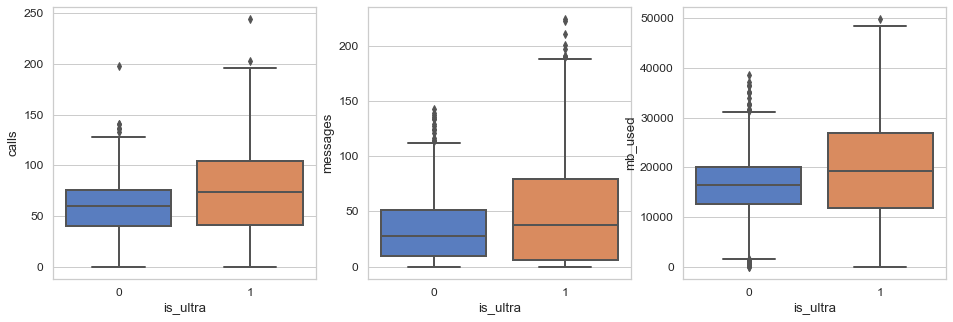

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
sns.boxplot(data=df, y='calls', x='is_ultra', ax=axes[0])
sns.boxplot(data=df, y='messages', x='is_ultra', ax=axes[1])
sns.boxplot(data=df, y='mb_used', x='is_ultra', ax=axes[2])
plt.show()

# Разработка модели

Основываясь на данных предыдущего исследования, пользователи тарифа ultra использовали больший объем услуг. Поэтому введем дополнительный признак, который зависит от количества категорий, в которых пользователь превысил бесплатный лимит входящий в пакет smart.

In [12]:
df['is_consume_a_lot'] = df.apply(lambda x: (int(x[2]>tariffs.messages_included[0]) +
                                             int(x[1]>tariffs.minutes_included[0]) +
                                             int(x[3]>tariffs.mb_per_month_included[0]) +
                                             2*int(x[3]>tariffs.mb_per_month_included[1])),
                                  raw=True, axis=1)

Удалим лишний признак и выбросы.

In [13]:
df = df.query('(calls < 150 and is_ultra==0) or (calls < 220 and is_ultra==1)')

In [14]:
df.drop(columns='minutes', inplace=True)

In [15]:
df.shape

(3212, 5)

In [16]:
# Идеи которые не вошли в итоговое решение.

# df.calls = np.log1p(df.calls)
# df.messages = np.log1p(df.messages)
# df.mb_used = np.log1p(df.mb_used)

# bins = [-1, 0, 2, 3.5, 6]
# labels = [0, 'low', 'avg', 'big']
# df['messages_group'] = pd.cut(df.messages, bins=bins, labels=labels).copy()

## Разбивание данных на выборки

In [17]:
features = df.drop(columns='is_ultra')

# X - матрица признаков, y - целевая переменная.
X = pd.get_dummies(features).reset_index(drop=True)
y = df['is_ultra']

In [18]:
X.head()

,calls,messages,mb_used,is_consume_a_lot
0,40.000,83.000,19915.420,2
1,85.000,56.000,22696.960,3
2,77.000,86.000,21060.450,2
3,106.000,81.000,8437.390,2
4,66.000,1.000,14502.750,0


Создадим тренировочные и тестовые выборки.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=38)

## Исследование и выбор моделей

Оценим как модели ведут себя со стандартными гиперпараметрами.

Для этого сначала определим функцию вывода.

In [20]:
def model_results(func):
    model = func
    # Находим значение целевой переменной после обучения модели.
    y_hat = model.fit(X_train, y_train).predict(X_test)
    # Вывод матрицы ошибок.
    ConfusionMatrixDisplay.from_predictions(y_test, y_hat,
                                            cmap='Blues', colorbar=False)
    plt.grid(b=None)
    plt.show()
    # Отображаем основные оценки классификатора.
    print('\nРезультат на тестовой выборке:')
    display(pd.DataFrame({'Качество':[accuracy_score(y_test,y_hat)],
                          'Точность':[precision_score(y_test,y_hat)],
                          'Полнота':[recall_score(y_test,y_hat)]}, index=['Параметр']))

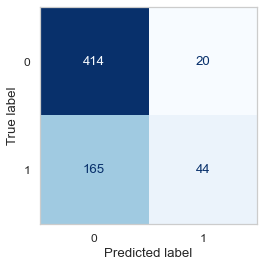


Результат на тестовой выборке:


,Качество,Точность,Полнота
Параметр,0.712,0.688,0.211


In [21]:
model_results(LogisticRegression())

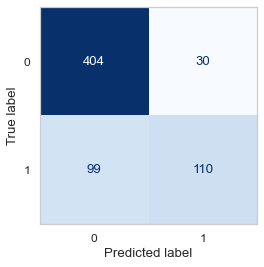


Результат на тестовой выборке:


,Качество,Точность,Полнота
Параметр,0.799,0.786,0.526


In [22]:
model_results(RandomForestClassifier())

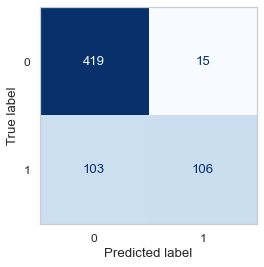


Результат на тестовой выборке:


,Качество,Точность,Полнота
Параметр,0.816,0.876,0.507


In [23]:
model_results(GradientBoostingClassifier())

* Результаты для логистической регрессии благодаря признаку is_consume_a_lot стали лучше, но полнота всё равно не большая, много ошибок второго рода.
* Случайный лес и градиентный бустинг показывают хороший результат, хотя полнота равна ~0.5.

## Определение моделей и кросс-валидация

Для решения задачи используем 2 базовых классификатора RandomForestClassifier и GradientBoostingClassifier. Окончательное решение будет принимать VotingClassifier.

In [24]:
rf_cla = RandomForestClassifier(random_state = 38, class_weight='balanced')
gb_cla = GradientBoostingClassifier(random_state = 38, min_samples_leaf=9)

In [25]:
# Сетка гиперпараметров по которым настраивается модель.
param_grid = {
    "v_cla__rf_cla__n_estimators": [100, 125, 150, 200],
    "v_cla__rf_cla__min_samples_split": [2, 5, 10, 12, 15, 20],
    "v_cla__rf_cla__criterion": ['gini', 'entropy'],
    "v_cla__gb_cla__n_estimators": [50, 100, 125],
}

# Задаем, используем параметр soft так как для всего 2 моделей взвешивание предсказаний подходит лучше.
v_cla = VotingClassifier([
    ('rf_cla', rf_cla),
    ('gb_cla', gb_cla),
],  n_jobs=-1, voting='soft')

# Формируем пайплайн в котором применяем регуляризацию StandardScaler (среднее=0, sd=1).
pipe = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('v_cla', v_cla)
])

Найдем лучшую комбинацию параметров используя GridSearchCV c 5 фолдами.

In [26]:
search = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('v_cla',
                                        VotingClassifier(estimators=[('rf_cla',
                                                                      RandomForestClassifier(class_weight='balanced',
                                                                                             random_state=38)),
                                                                     ('gb_cla',
                                                                      GradientBoostingClassifier(min_samples_leaf=9,
                                                                                                 random_state=38))],
                                                         n_jobs=-1,
                                                         voting='soft'))]),
             n_jobs=-1,
             param_grid={'v_cla__gb_cla__n_estimators': [50, 100, 125],

## Проверка модели на тестовой выборке. Sanity check.

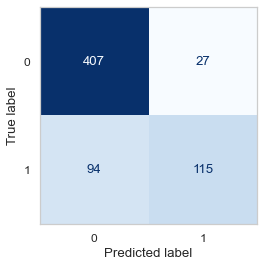


Результат на тестовой выборке:


,Качество,Точность,Полнота
Параметр,0.812,0.810,0.550


Лучшая оценка на тренировочной выборке: 0.867
Лучшая оценка на CV: 0.815


In [27]:
# в качестве модели используем best_estimator_ с оптимизированными гиперпараметрами.
model_results(search.best_estimator_)
print(f'Лучшая оценка на тренировочной выборке: {search.score(X_train, y_train):0.3f}')
print(f'Лучшая оценка на CV: {search.best_score_:0.3f}')

Значения гиперпараметров найденных в результате кросс-валидации.

In [28]:
print(search.best_params_)

{'v_cla__gb_cla__n_estimators': 100, 'v_cla__rf_cla__criterion': 'gini', 'v_cla__rf_cla__min_samples_split': 10, 'v_cla__rf_cla__n_estimators': 150}


# Выводы:

* В результате исследования выбрана модель, которая имеет высокое качество и точность.
* Подобраны оптимальные гиперпараметры. Выполнена кросс-валидация и проверка на тестовой выборке.
* Обнаружено что модели не обеспечивают высокий параметр recall, достаточно много ошибок второго рода.
* Получена accuracy ~0.81 на тестовой выборке.
* Выполнена проверка модели на адекватность.

## Чек-лист готовности проекта
- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки (GridSearchCV)
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75